# Recreational Areas In Los Angeles
#### Kayla Chaoui z5214021

Data provided by the California Department of Parks and Recreation and the U.S. 2010 Census.

The dataset published by the California Department of Parks and Recreation lists the recreational facilities in the LA city area including details of their type, locations and council association. This analysis incorporated the 2010 Census data for LA which was comprised of each zip code's population, median age and households.

In [103]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import geopandas as gp
import shapely
import fiona

In [30]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)
saved_style_state = matplotlib.rcParams.copy() 

In [31]:
#Getting data from file path
def getdata(filepath):
    if os.path.isfile(filepath):

        print("loading from file")
        print("done")
    else:
        print("Put ur file there")
    return(pd.read_csv(filepath, low_memory=False))

In [54]:
dfrec_data= getdata("park_info.csv")
#dfrec_data=dfrec_data.drop(dfrec_data.index[101]) #removes the 92325 zip code, it is not in the LA city region so it has no census data
print(dfrec_data[dfrec_data['Zip']== 92325].index.values)
dfrec_data=dfrec_data.drop(dfrec_data.index[855])


dfcensus = getdata("census.csv")
dfcensus_data=dfcensus.rename(columns=({'Zip Code':'Zip','Total Population':'Population','Median Age':'MedianAge','Total Males':'Males','Total Females':'Females','Total Households':'Households','Average Household Size':'AvgHouseholdSize'}))


loading from file
done
[855]
loading from file
done


In [55]:
dfrec_data.GeoLong=dfrec_data.GeoLong.apply(lambda x:x if x < -118 else None) #this cleaned the data, there were two outliers that affected the mapping and graphing of the data
#dfrec_data.GeoLong.hist()

In [86]:
counts=dfrec_data["Zip"].value_counts()
reccounts = pd.DataFrame(counts)
reccounts["new_column"] = reccounts.index
reccounts.reset_index(drop=True, inplace=True)
reccounts=reccounts.rename(columns=({'Zip':'Total_Count','new_column': 'Zip'}))
columns_titles = ["Zip","Total_Count"]
reccounts=reccounts.reindex(columns=columns_titles)

zipinfo=pd.DataFrame(dfcensus_data)

dfmerged_data= pd.merge(zipinfo,reccounts, on="Zip")

locTypes=dfrec_data.LocationType.tolist()
locTypes = list(dict.fromkeys(locTypes))

for facility in locTypes:
    parks = dfrec_data["Zip"][dfrec_data["LocationType"] == facility].value_counts()
    parkcounts = pd.DataFrame(parks)
    parkcounts[f"{facility}"] = parkcounts.index
    parkcounts.reset_index(drop=True, inplace=True)
    parkcounts=parkcounts.rename(columns=({'Zip':f"{facility}",f"{facility}": 'Zip'}))
   
    dfmerged_data= pd.merge(dfmerged_data,parkcounts, on="Zip", how='outer') 

dfmerged_data

Zip  Population  MedianAge  Males  Females  Households  \
0    90002       51223       25.5  24876    26347       11731   
1    90003       66266       26.3  32631    33635       15642   
2    90004       62180       34.8  31302    30878       22547   
3    90006       59185       32.4  30254    28931       18617   
4    90007       40920       24.0  20915    20005       11944   
..     ...         ...        ...    ...      ...         ...   
96   91601       37180       32.9  18932    18248       15970   
97   91602       17473       38.0   8722     8751        9277   
98   91604       29034       40.2  14271    14763       14292   
99   91605       56343       31.9  28417    27926       15357   
100  91606       44958       34.3  22376    22582       14903   

     AvgHouseholdSize  Total_Count  Parks  Gardens  ...  \
0                4.36            7    1.0      1.0  ...   
1                4.22           14    4.0      NaN  ...   
2                2.73            2    2.0      NaN  ...   
3                3.13            7    4.0      NaN  ...   
4                3.00            7    3.0      NaN  ...   
..                ...          ...    ...      ...  ...   
96               2.32           14    4.0      NaN  ...   
97               1.88            4    2.0      NaN  ...   
98               2.01           10    4.0      NaN  ...   
99               3.61            6    5.0      NaN  ...   
100              3.00           13    4.0      NaN  ...   

     Swimming Pools - Summer  Golf Courses  Theatre  Equestrian Centers  \
0                        NaN           NaN      NaN                 NaN   
1                        1.0           NaN      NaN                 NaN   
2                        NaN           NaN      NaN                 NaN   
3                        NaN           NaN      NaN                 NaN   
4                        NaN           NaN      NaN                 NaN   
..                       ...           ...      ...                 ...   
96                       1.0           NaN      NaN                 NaN   
97                       NaN           NaN      NaN                 NaN   
98                       NaN           NaN      NaN                 NaN   
99                       NaN           NaN      NaN                 NaN   
100                      1.0           NaN      NaN                 NaN   

     Hiking Trails  Senior Centers  Camps  Beaches  Rental Facilities  \
0              NaN             1.0    NaN      NaN                NaN   
1              NaN             1.0    NaN      NaN                NaN   
2              NaN             NaN    NaN      NaN                NaN   
3              NaN             NaN    NaN      NaN                NaN   
4              NaN             NaN    NaN      NaN                NaN   
..             ...             ...    ...      ...                ...   
96             1.0             2.0    NaN      NaN                NaN   
97             NaN             NaN    NaN      NaN                NaN   
98             NaN             NaN    NaN      NaN                NaN   
99             NaN             NaN    NaN      NaN                NaN   
100            NaN             NaN    NaN      NaN                NaN   

     Open Space  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  
..          ...  
96          NaN  
97          NaN  
98          NaN  
99          NaN  
100         NaN  

[101 rows x 31 columns]

# Plots 

In [106]:
def Location_types():
    Typecounts = dfrec_data["LocationType"].value_counts()
    Typecounts[Typecounts < 5000].plot(kind="bar",color=['#221A7C','#202785','#1D348E','#1B4297', '#184FA0', '#165CA9'  , '#1369B2', '#0979B9',"#0089c0", '#0095C2', '#00A2C4', '#00AEC5', \
             '#00BAC7', '#16C0C5','#2BC5C3', '#41CBC0', '#56D0BE', '#6CD6BC', '#77DABB',  '#83DEBA', '#8EE1B8',  '#9AE5B7', \
              '#A5E9B6', '#B0EDB5', '#BCF0B3', '#C7F4B2', '#CCF5B4', '#D1F7B6', '#DCFAB9', '#E6FCBD', '#F0FFC0'], width=1)
    plt.xticks(fontsize=10, family = 'avenir', rotation='90')
    plt.title("Recreational Facilities in LA by Type", fontsize=20 ,family = 'avenir')
    plt.xlabel('\n Recreational Facilities', fontsize=15 ,family = 'avenir')
    plt.ylabel('Quantity', fontsize=15, rotation='vertical', ha='right',family = 'avenir')
    return(plt.show()) 
    
    
dfrec_data["LocationType"].value_counts()

Parks                                 387
Recreation Centers                    156
Public Computer Centers                76
Outdoor Fitness Equipment              67
Tennis Courts                          67
Swimming Pools - Summer                34
Senior Centers                         34
Universally Accessible Playgrounds     33
Skate Parks                            23
Swimming Pools - Year Round            17
Golf Courses                           15
Museums                                15
Hiking Trails                          14
Gardens                                10
Dog Parks                               9
Lakes                                   7
Free Wi-Fi Hot Spots                    6
Equestrian Centers                      4
Camps                                   3
Rental Facilities                       3
Theatre                                 2
Beaches                                 2
Open Space                              1
Name: LocationType, dtype: int64

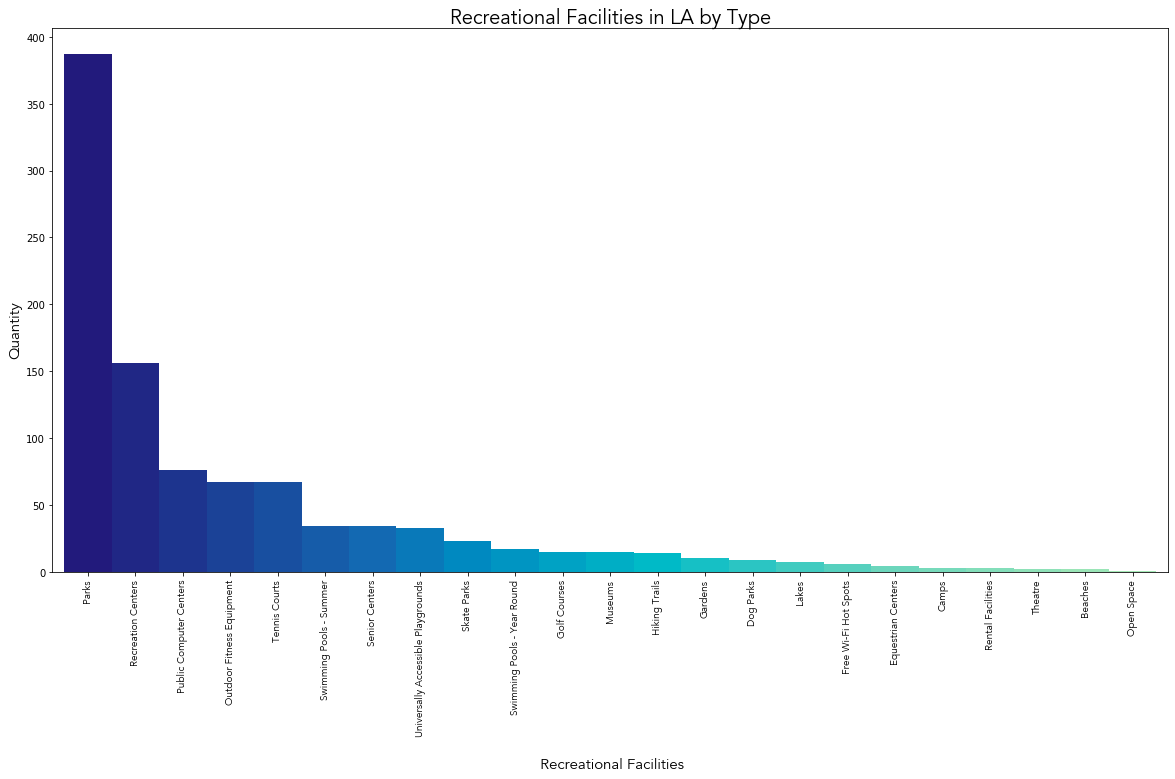

In [60]:
Location_types()

In [61]:
def zipcodes_count():
    Zipcounts = dfrec_data["Zip"].value_counts()
    Zipcounts[Zipcounts < 5000].plot(kind="bar", color=['#F1BD96'], edgecolor='white')

    plt.yticks(fontsize=10, family = 'avenir')
    plt.xticks(fontsize=10, family = 'avenir', rotation='90')
    plt.title("Number of Recreational Facilities per Zip Code", fontsize=20 ,family = 'avenir')
    plt.xlabel('\n Zip Codes', fontsize=15 ,family = 'avenir')
    plt.ylabel('Number of Recreational Facilities', fontsize=15, rotation='vertical', ha='right',family = 'avenir')
    #90027 has the highest number of rec facilities, it is a park containing zoos, trails and other things
    plt.show()

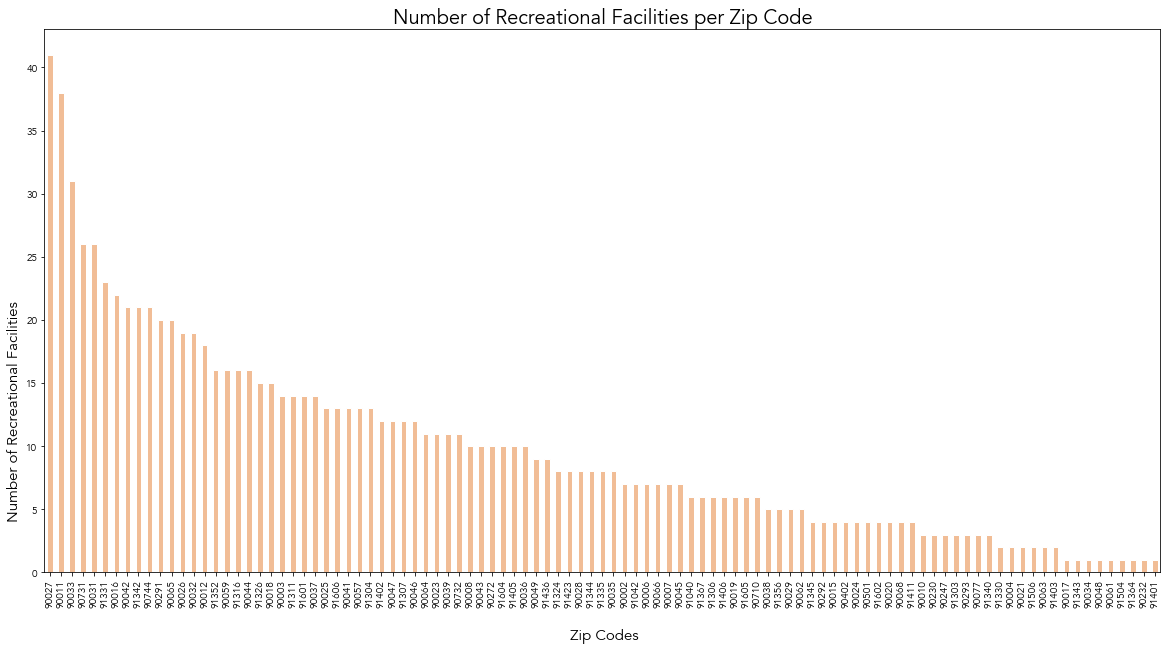

In [62]:
zipcodes_count()

In [63]:
dfrec_data.head(1)

LocationType                    Location Name  StNumber StNumberFraction  \
0        Parks  La Mirada Park Acquisition Site    5401.0              NaN   

  StDirection     StName StSuffix StSuffixDirection AddressType  \
0           W  La Mirada      Ave               NaN         NaN   

   AddressTypeValue  ...  CrossStSuffix CrossStSuffixDirection  \
0               NaN  ...            NaN                    NaN   

                                         City  State    Zip Website  \
0  Los Angeles, CA 90029\n(34.0942, -118.307)     CA  90029     NaN   

            Phone CouncilDistrict     GeoLat     GeoLong  
0  (310) 548-7675              13  34.094208 -118.306999  

[1 rows x 22 columns]

In [64]:
dfrec_data["Zip"].value_counts()

90027    41
90011    38
90033    31
90731    26
90031    26
         ..
90061     1
91504     1
91364     1
90232     1
91401     1
Name: Zip, Length: 101, dtype: int64

In [66]:
def council_count():
    council = dfrec_data["CouncilDistrict"].value_counts()
    council[council < 5000].plot(kind="bar", color=['#F1BD96'], edgecolor='white')

    plt.yticks(fontsize=10, family = 'avenir')
    plt.xticks(fontsize=10, family = 'avenir', rotation='90')
    plt.title("Number of Recreational Facilities per Council District", fontsize=20 ,family = 'avenir')
    plt.xlabel('\n Council Districts', fontsize=15 ,family = 'avenir')
    plt.ylabel('Number of Recreational Facilities', fontsize=15, rotation='vertical', ha='right',family = 'avenir')
    plt.show()

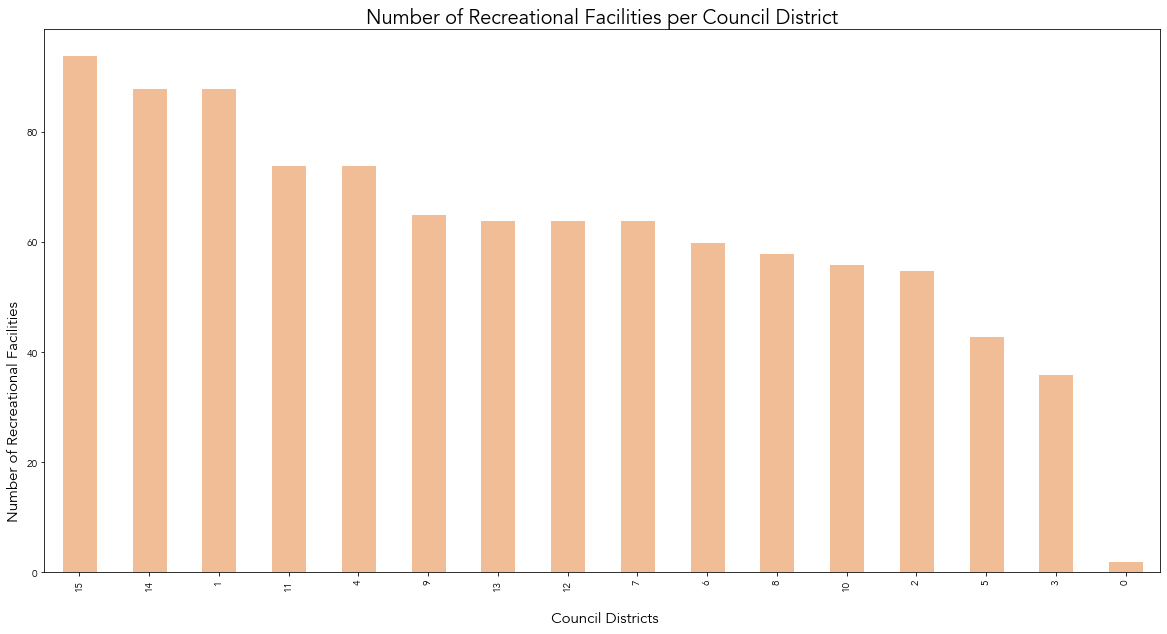

In [67]:
council_count()

In [104]:
types=dfmerged_data.columns.tolist()
def stacked():
    dfmerged_data.loc[:,['Parks', 'Gardens', 'Outdoor Fitness Equipment', 'Dog Parks', 
                         'Public Computer Centers', 'Tennis Courts', 'Recreation Centers', 'Lakes', 
                         'Universally Accessible Playgrounds', 'Swimming Pools - Year Round', 
                         'Free Wi-Fi Hot Spots', 'Skate Parks', 'Museums', 'Swimming Pools - Summer',
                         'Golf Courses', 'Theatre', 'Equestrian Centers', 'Hiking Trails', 'Senior Centers', 
                         'Camps', 'Beaches', 'Rental Facilities', 'Open Space']].plot.bar(stacked=True)
    
    plt.yticks(fontsize=10, family = 'avenir')
    plt.xticks(fontsize=10, family = 'avenir', rotation='90')
    plt.title("Breakdown of Facility Type Per Zip Code", fontsize=20 ,family = 'avenir')
    plt.xlabel('\n Zip Codes', fontsize=15 ,family = 'avenir')
    plt.ylabel('Number of Recreational Facilities', fontsize=15, rotation='vertical', ha='right',family = 'avenir')
    plt.show()
    

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xticks'

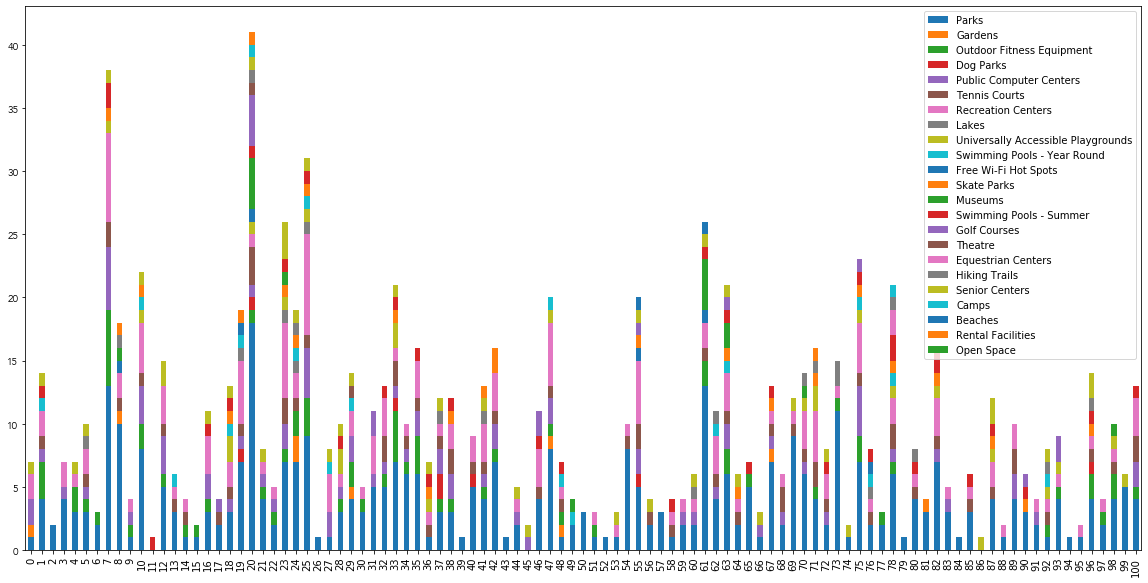

In [99]:
stacked()

In [68]:
def facilities_count():
    Zipcounts = dfrec_data["Zip"].value_counts()
    Zipcounts[Zipcounts < 5000].plot(kind="hist", bins=15, color=['#F1BD96'], edgecolor='white')

    plt.yticks(fontsize=10, family = 'avenir')
    plt.xticks(fontsize=10, family = 'avenir')
    plt.title("Number of Recreational Facilities per Zip Code", fontsize=20 ,family = 'avenir')
    plt.xlabel('\n Number of Recreational Facilities', fontsize=15 ,family = 'avenir')
    plt.ylabel('Number of Zip Codes', fontsize=15, rotation='vertical', ha='right',family = 'avenir')
    #90027 has the highest number of rec facilities, it is a park containing zoos, trails and other things
    return plt.show()

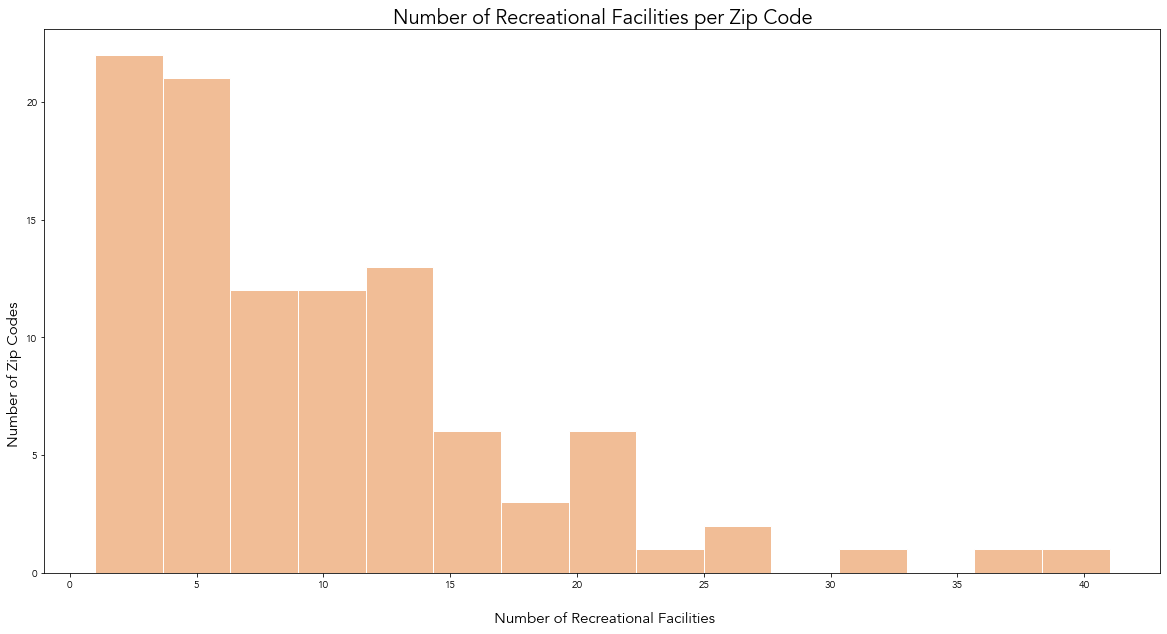

In [69]:
facilities_count()

In [33]:
def age_correlation():

    df = pd.DataFrame({'Count': dfmerged_data["Total_Count"] , 'Age':dfmerged_data["MedianAge"], 'Zip':dfmerged_data["Zip"] })
    #df.sort_values(by='Count', inplace=True)
    fig,ax1 = plt.subplots()
    ax2 = ax1.twinx()

    df.plot(x= 'Zip', y= 'Count',kind='bar', color='#F1BD96', ax=ax1, position = 1)
    df['Age'].plot(kind='bar', color='#a8dded', ax=ax2,position = 0)
    ax1.yaxis.tick_right()
    ax2.yaxis.tick_left()
    ax1.set_ylabel('Median Age', labelpad = 30 , family = 'avenir')
    ax2.set_ylabel('Recreational Facilities Count', labelpad = 30, family = 'avenir')
    ax1.set_xlabel('Zip Code')
    plt.title("Correlation Between Number of Recreational Facilities and Median Age Per Zip Code", fontsize=15 ,family = 'avenir')
    return plt.show()
    

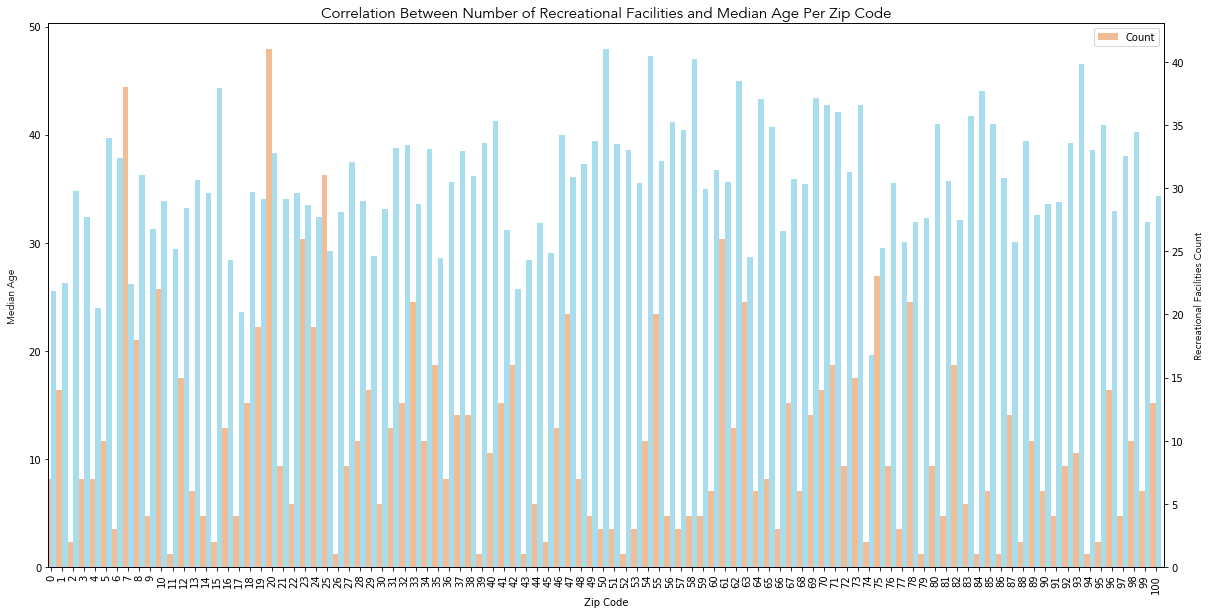

In [34]:
age_correlation()

In [35]:
def age_scatter():
    df = pd.DataFrame({'Count': dfmerged_data["Total_Count"] , 'Age':dfmerged_data["MedianAge"], 'Zip':dfmerged_data["Zip"] })

    plt.scatter(x= df.Age, y= df.Count, color='y')
    #ax1.set_ylabel('Median Age', labelpad = 30 , family = 'avenir')
    #ax2.set_ylabel('Recreational Facilities Count', labelpad = 30, family = 'avenir')
    #ax1.set_xlabel('Zip Code')
    plt.title("Correlation Between Number of Recreational Facilities and Median Age Per Zip Code", fontsize=15 ,family = 'avenir')
    return plt.show()

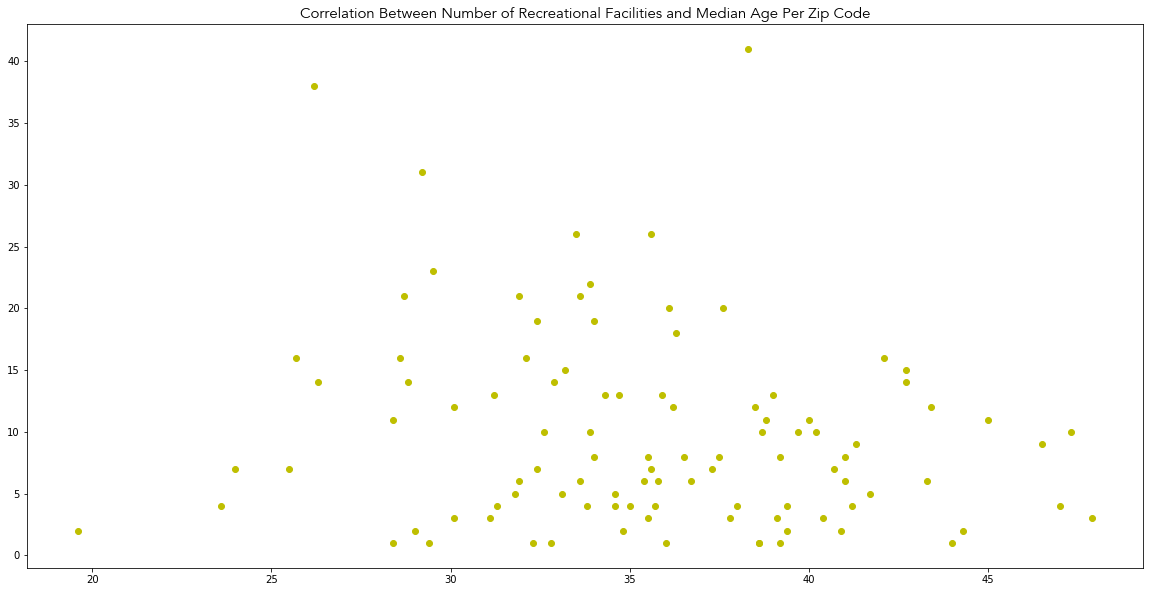

In [36]:
age_scatter()

In [37]:
def pop_correlation():
    df = pd.DataFrame({'Count': dfmerged_data["Total_Count"] , 'Pop':dfmerged_data["Population"], 'Zip':dfmerged_data["Zip"] })

    fig,ax1 = plt.subplots()
    ax2 = ax1.twinx()

    df.plot(x= 'Zip', y= 'Count',kind='bar', color='#F1BD96', ax=ax1)
    df['Pop'].plot(x = 'Zip', y='Pop',kind='line', marker='d', color='#a8dded', ax=ax2)
    ax1.yaxis.tick_right()
    ax2.yaxis.tick_left()
    ax1.set_ylabel('Total Population', labelpad = 50 , family = 'avenir')
    ax2.set_ylabel('Recreational Facilities Count', labelpad = 30, family = 'avenir')
    ax1.set_xlabel('Zip Code',labelpad = 10, family = 'avenir')
    plt.title("Correlation Between the Number of Recreational Facilities and Total Population Per Zip Code", fontsize=15 ,family = 'avenir')
    return plt.show()

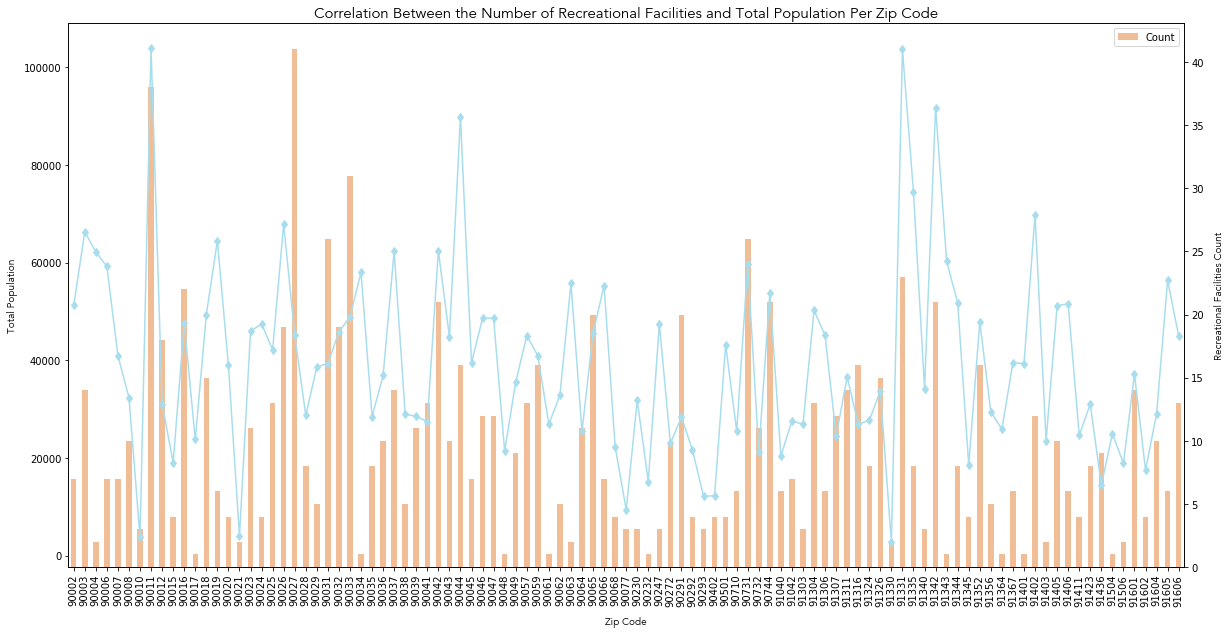

In [38]:
pop_correlation()

In [39]:
def pop_scatter():
    plt.scatter(x= dfmerged_data["Population"], y= dfmerged_data["Total_Count"], color='y')
    plt.title("Correlation Between Number of Recreational Facilities and Population Per Zip Code", fontsize=15 ,family = 'avenir')
    return plt.show()

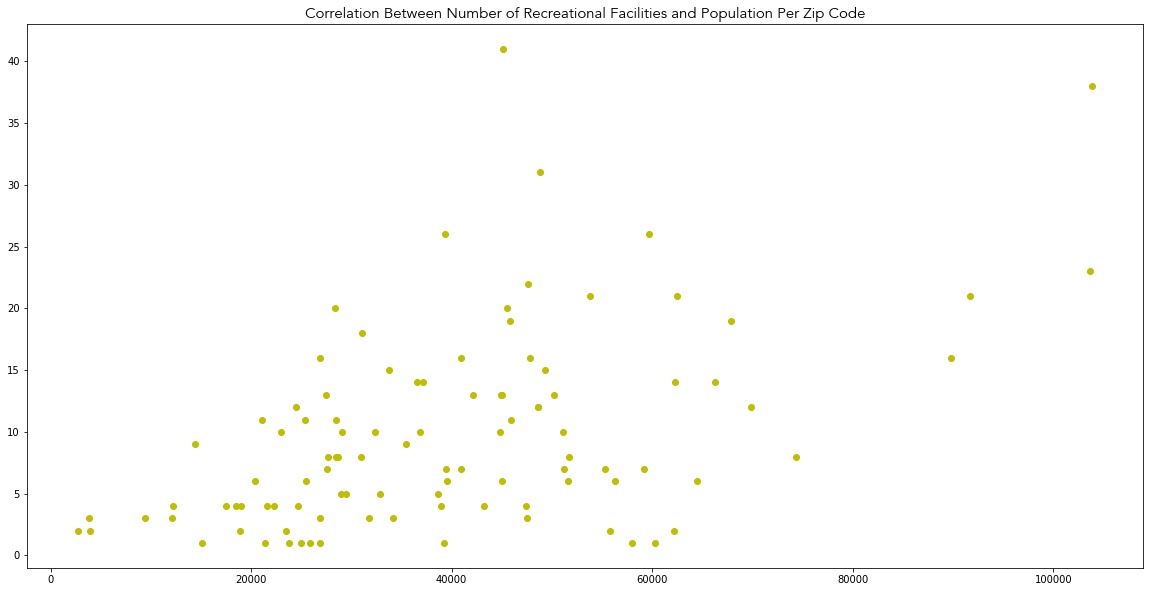

In [40]:
pop_scatter()

In [123]:
def house_scatter():
    plt.scatter(x= dfmerged_data["Households"], y= dfmerged_data["Total_Count"], color='y')
    plt.title("Correlation Between Number of Recreational Facilities and Population Per Zip Code", fontsize=15 ,family = 'avenir')
    return plt.show()

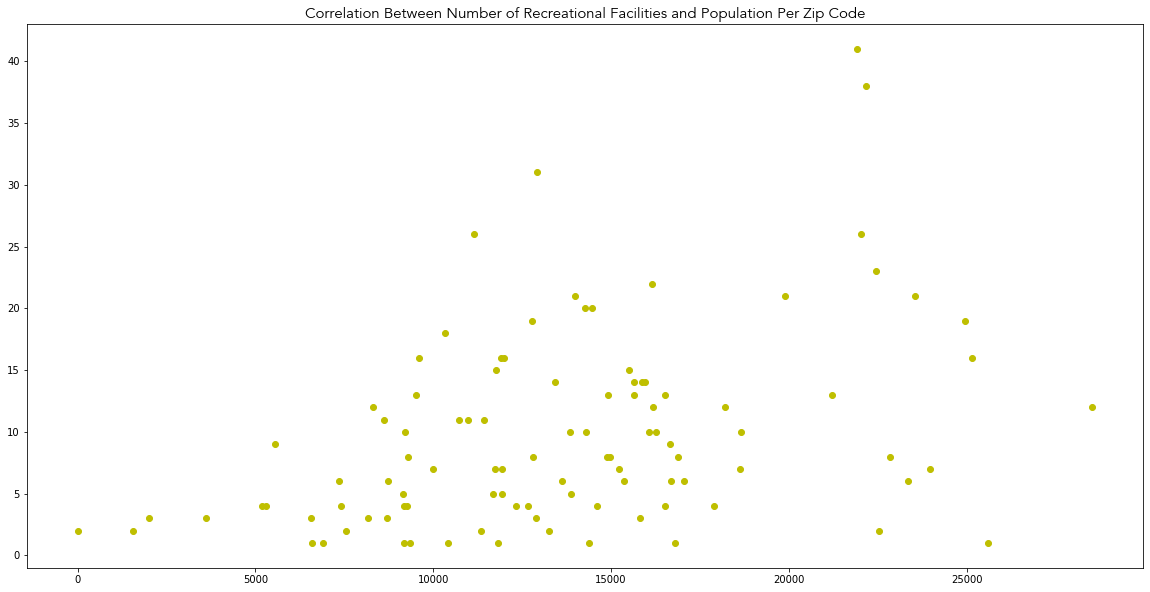

In [124]:
house_scatter()

In [115]:
def senior_scatter():
    plt.scatter(x= dfmerged_data["Households"], y= dfmerged_data["Universally Accessible Playgrounds"], color='y')
    plt.title("Correlation Between Number of Recreational Facilities and Population Per Zip Code", fontsize=15 ,family = 'avenir')
    return plt.show()



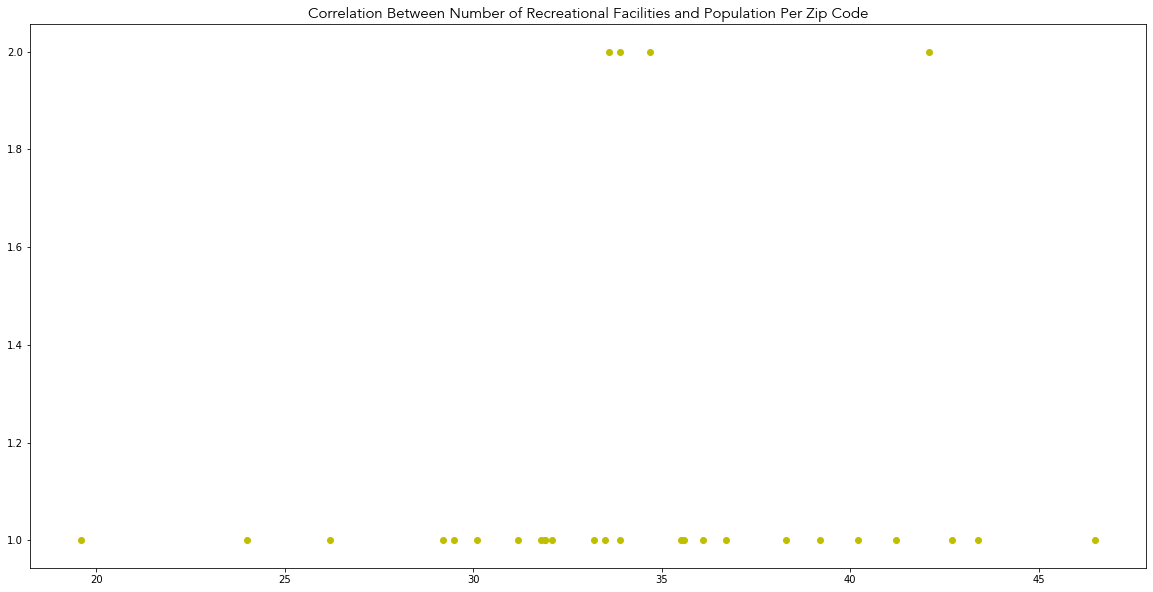

In [110]:
senior_scatter()

# Maps

In [111]:
#MAPS AND PLOTS

#dfrec_data['geometry'] = dfrec_data.apply(lambda row: shapely.geometry.point.Point(row.GeoLat, row.GeoLong),axis = 1)


park_points = gp.GeoDataFrame(dfrec_data, geometry=gp.points_from_xy(dfrec_data.GeoLong, dfrec_data.GeoLat))
#park_points.plot()

county = gp.GeoDataFrame.from_file("LA_County_Boundaries-shp/LA_County_City_Boundaries.shp")
#county.head(2)
#county.plot90

city = gp.GeoDataFrame.from_file("LA_City_Boundaries-shp/LA_County_City_Boundaries.shp")
#city.head(2)
#city.plot()

zip = gp.GeoDataFrame.from_file("Los_Angeles_City_Zip_Codes-shp/b982f3c3-ffe6-4e4a-b8e6-2bd1eb2c70642020328-1-26h3sc.00ox.shp")
zip.head(2)
#zip.plot()

OBJECTID CITY ZIPCODE    ZIP          TOOLTIP NLA_URL  AnalysisAr  \
0         1   IN   90001  90001  Zip Code: 90001       n    0.928396   
1         2   IN   90002  90002  Zip Code: 90002       n    2.045266   

                                            geometry  
0  POLYGON ((-118.25632 33.98869, -118.25632 33.9...  
1  POLYGON ((-118.25591 33.96004, -118.25591 33.9...

In [112]:
def Map_County():
    fig, ax = plt.subplots()
    ax.set_aspect('equal')

    county.plot(ax=ax, color = "#cdf7f2",edgecolor='#51c2b3')
    city.plot(ax=ax, color = "#a8dded",edgecolor='#59a0b5')
    park_points.plot(ax=ax, color='#184FA0', marker=".", markersize=10)
    plt.title("The City of LA Recreational Centre Locations in LA County")
    return plt.show()
    
    #for idx, row in gdf.iterrows():

     #   plt.annotate(s=row["Location Name"], 
     #                xy=[row.geometry.x,row.geometry.y],
     #                horizontalalignment='center')
    #plt.title("Some pretty dodgy suburb names on a map");
    #plt.show()


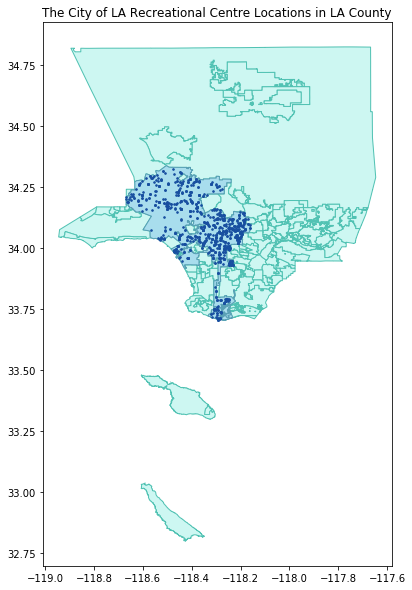

In [113]:
Map_County()

In [31]:
def Map_City():   
    fig, ax = plt.subplots()
    ax.set_aspect('equal')

    zip.plot(ax=ax, color = "#a8dded",edgecolor='white')
    park_points.plot(ax=ax, color='#e687db', marker=".", markersize=10)
    plt.title("Recreational Centres in the City of LA")
    return plt.show()

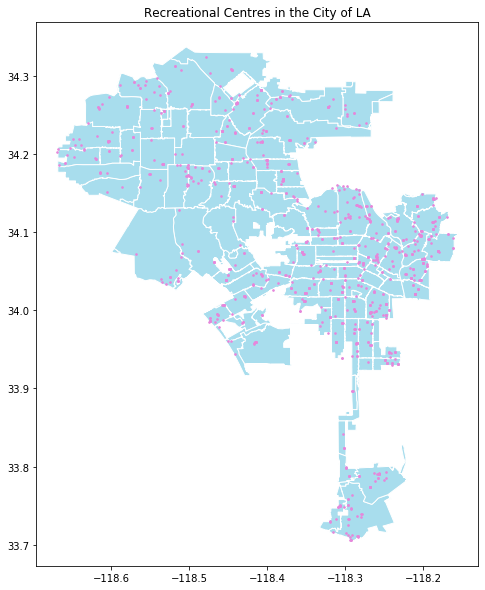

In [32]:
Map_City()